In [7]:
# PyTorch
import torch

x = torch.rand(3, 3)
y = torch.ones(3, 3)
print(x)
print(x.T)
print(y)
print(x + y)
print(x @ y)

tensor([[0.2072, 0.5177, 0.1196],
        [0.6218, 0.9738, 0.5396],
        [0.8200, 0.5657, 0.6341]])
tensor([[0.2072, 0.6218, 0.8200],
        [0.5177, 0.9738, 0.5657],
        [0.1196, 0.5396, 0.6341]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1.2072, 1.5177, 1.1196],
        [1.6218, 1.9738, 1.5396],
        [1.8200, 1.5657, 1.6341]])
tensor([[0.8445, 0.8445, 0.8445],
        [2.1352, 2.1352, 2.1352],
        [2.0199, 2.0199, 2.0199]])
tensor([7., 9.])


In [8]:
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = x ** 2 + 3 * x + 1
z = y.sum()

# 역전파
z.backward()
# 역전파된 기울기 확인
print(x.grad)

tensor([7., 9.])


In [9]:
# 장치 관리
device = 'cpu'

# windows - cuda
if torch.cuda.is_available():
    device = 'cuda'
# apple silicon - mps
if torch.mps.is_available():
    device = torch.device('mps')
print(device)

# x.to(device)


cpu


In [10]:
# 난수 고정
import numpy as np
import random
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# windows - cuda
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# apple silicon - mps
if torch.mps.is_available():
    torch.mps.manual_seed(SEED)
    torch.use_deterministic_algorithms(True, warn_only=True)

In [15]:
"""
선형 회귀 모델을 PyTorch로 구현
"""

from torch import nn
from torch import optim

# 더미 데이터 생성
X = torch.linspace(0, 10, 100).unsqueeze(1)  # 0~10 을 100등분 한 2차원 배열 생성
# 2*x + 1 의 회귀 모델 구현을 목표로 하는 라벨
y_true = 2 * X + 1 + 0.5 * torch.randn_like(X)


# 1차원 입력, 1차원 출력의 선형 모델을 만들것이다
model = nn.Linear(1, 1)
# 비용함수는 MSE 사용
criterion = nn.MSELoss()
# SGD로 파라미터를 갱신
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 학습 시작
epochs = 1
for epoch in range(epochs):
    # 기울기 초기화
    optimizer.zero_grad()
    # 예측 진행
    y_pred = model(X)
    # 손실 계산
    loss = criterion(y_pred, y_true)
    # 비용의 미분 계산
    loss.backward()
    # 매개변수 업데이트
    optimizer.step()
    # 20번의 학습마다 기록
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print('학습된 가중치 + 편향')
for name, param in model.named_parameters():
    print(f'{name}: {param.data}')

학습된 가중치 + 편향
weight: tensor([[1.6438]])
bias: tensor([0.6909])


1.6438459157943726 0.6908526420593262


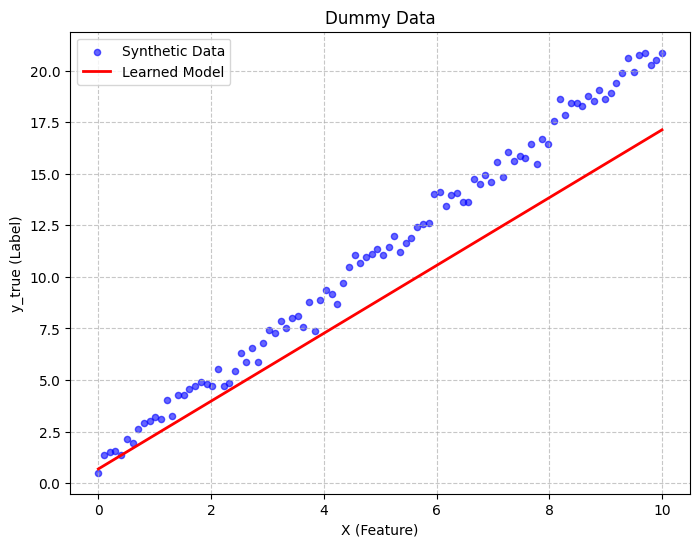

In [16]:
# 실제 데이터와 회귀선 비교
def show_data():
    X_np = X.squeeze().numpy()
    y_true_np = y_true.squeeze().numpy()
    w_learned = model.weight.item()
    b_learned = model.bias.item()
    print(w_learned, b_learned)
    y_line_np = w_learned * X_np + b_learned

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(X_np, y_true_np, s=20, color='b', alpha=0.6, label='Synthetic Data')
    plt.plot(X_np, y_line_np, color='red', linewidth=2, label=f'Learned Model')

    plt.title('Dummy Data')
    plt.xlabel('X (Feature)')
    plt.ylabel('y_true (Label)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
show_data()

In [17]:
"""
입력 - 은닉 - 출력 구조의 MLP 만들기
"""

import torch
from torch import nn

# 어떤 계층을 넣을지를 결정해서 층 구조를 class로 정의
class SimpleMLP(nn.Module):
    # 각 층의 뉴련의 갯수는 인스턴스를 만들 때 결정
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    # nn.Module()의 __call__이 호출될 때 자동으로 호출
    def forward(self, x):
        # 각 층을 순차적으로 호출
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class SequentialMLP(nn.Module):
    # 각 층의 뉴련의 갯수는 인스턴스를 만들 때 결정
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        # 각 층을 순차적으로 쌓는다
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    # nn.Module()의 __call__이 호출될 때 자동으로 호출
    def forward(self, x):
        return self.layers(x)

# 인스턴스 생성
model = SimpleMLP(20, 10, 1)
# 20개의 feature를 가진 40개의 데이터
X = torch.rand(size=(40,20))
# 모델을 이용해 예측하기
y_pred = model(X)
# 40개의 데이터에 대한 예측 출력 (1개씩 40줄)
print(y_pred.size())
y_pred

torch.Size([40, 1])


tensor([[-0.1510],
        [-0.1714],
        [-0.0102],
        [ 0.0364],
        [ 0.0081],
        [-0.1118],
        [ 0.0368],
        [-0.0993],
        [-0.0585],
        [-0.2317],
        [ 0.0269],
        [ 0.0323],
        [-0.0126],
        [-0.0032],
        [-0.0185],
        [-0.1743],
        [-0.0035],
        [-0.0848],
        [-0.1188],
        [-0.1561],
        [-0.0338],
        [ 0.0231],
        [-0.0713],
        [ 0.0402],
        [-0.1265],
        [-0.0363],
        [-0.1437],
        [ 0.0624],
        [-0.0678],
        [-0.0784],
        [-0.0219],
        [-0.0420],
        [ 0.0804],
        [-0.1430],
        [-0.0556],
        [-0.0770],
        [-0.0823],
        [ 0.0223],
        [ 0.0149],
        [-0.1693]], grad_fn=<AddmmBackward0>)